In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.model_selection import cross_val_score
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


# boston 데이타셋 로드
boston = load_boston()

# boston 데이타셋 DataFrame 변환 
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함. 
bostonDF['PRICE'] = boston.target
print('Boston 데이타셋 크기 :',bostonDF.shape)
bostonDF.head()

Boston 데이타셋 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


* CRIM: 지역별 범죄 발생률  
* ZN: 25,000평방피트를 초과하는 거주 지역의 비율
* NDUS: 비상업 지역 넓이 비율
* CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
* NOX: 일산화질소 농도
* RM: 거주할 수 있는 방 개수
* AGE: 1940년 이전에 건축된 소유 주택의 비율
* DIS: 5개 주요 고용센터까지의 가중 거리
* RAD: 고속도로 접근 용이도
* TAX: 10,000달러당 재산세율
* PTRATIO: 지역의 교사와 학생 수 비율
* B: 지역의 흑인 거주 비율
* LSTAT: 하위 계층의 비율
* MEDV: 본인 소유의 주택 가격(중앙값)

* 각 컬럼별로 주택가격에 미치는 영향도를 조사
* RM(방 개수)은 양의 방향 선형성(Positive Linearity)이 두드러진다. 방의 수가 많을수록 가격이 증가하는 보습이 확연하다.
* LSTAT(하위 계층 비율)는 음의 방향 선향성(Negative Linearity)이 가장 크다. LSTAT이 적을 수록 PRICE가 증가하는 모습이 확연하다.

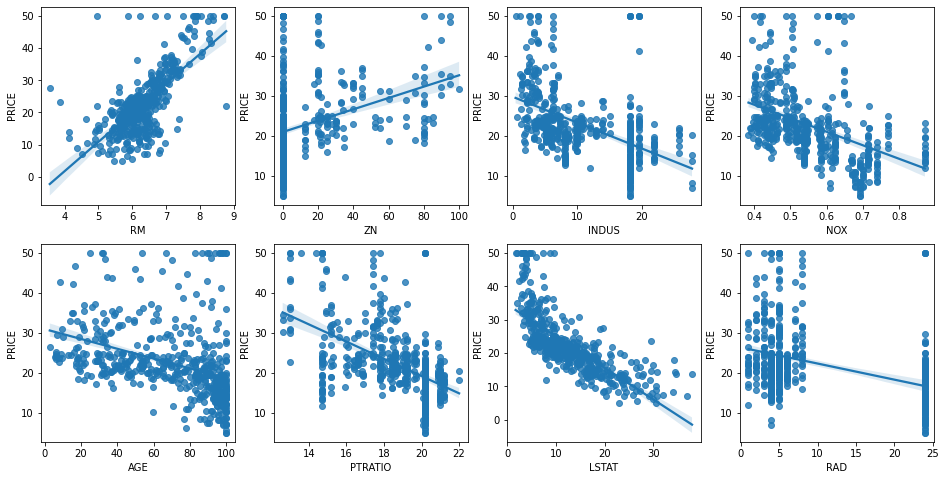

In [2]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8) , ncols=4 , nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i , feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature , y='PRICE',data=bostonDF , ax=axs[row][col])

**학습과 테스트 데이터 세트로 분리하고 학습/예측/평가 수행**
* MSE와 R2 Score확인

In [3]:
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

# Linear Regression OLS로 학습/예측/평가 수행. 
lr = LinearRegression()
lr.fit(X_train ,y_train )
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297 , RMSE : 4.159
Variance score : 0.757


In [4]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164755
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [5]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. index가 컬럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns )
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [6]:
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr = LinearRegression()

# cross_val_score( )로 5 Fold 셋으로 MSE 를 구한 뒤 이를 기반으로 다시  RMSE 구함. 
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수 
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))


 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 
